# Palmprint Recognition Pipeline

This notebook implements a complete pipeline for palmprint recognition, including:

1. Training the dataset with 3 models (Simple CNN, ResNet-50, EfficientNet, and InceptionV3).
2. Showing evaluation metrics for the models.
3. Preprocessing the dataset with the following steps:
   - Segmenting the hand palm only (removing the background).
   - Extracting the ROI based on the segmented hand palm.
   - Applying CLAHE for handling different lighting conditions.
   - Applying Gabor filter for enhancing the palmprint.
   - Converting all images to grayscale.
4. Saving the preprocessed dataset to a new folder named `preprocessed_dataset`.
5. Training the models using the preprocessed dataset.
6. Displaying samples of the dataset before and after preprocessing.

In [4]:
# Import necessary libraries
import os
import cv2
import numpy as np
import math
import tensorflow as tf
import shutil
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [5]:
# --------------------- 
#       CONFIG 
# ---------------------
RAW_PATH = 'test_local'
SPLIT_PATH = 'dataset_splitted'
PREPROCESSED_PATH = 'preprocessed_dataset'

RATIOS = {0.75, 0.15, 0.10}         # Train, Val, Test
np.random.seed(42)                  # For reproducibility

In [6]:
# load dataset
def load_dataset(path):
    data, labels = [], []
    if not os.path.exists(path):                                    # if path does not exist
        print("Path does not exist.")
        return np.array(data), np.array(labels)                         # return empty arrays
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    resized_img = cv2.resize(img, (256, 256))       # resize to same size, cause model input must be same size
                    data.append(resized_img)
                    labels.append(label)
    return np.array(data), np.array(labels)

Dataset loaded with 400 images.


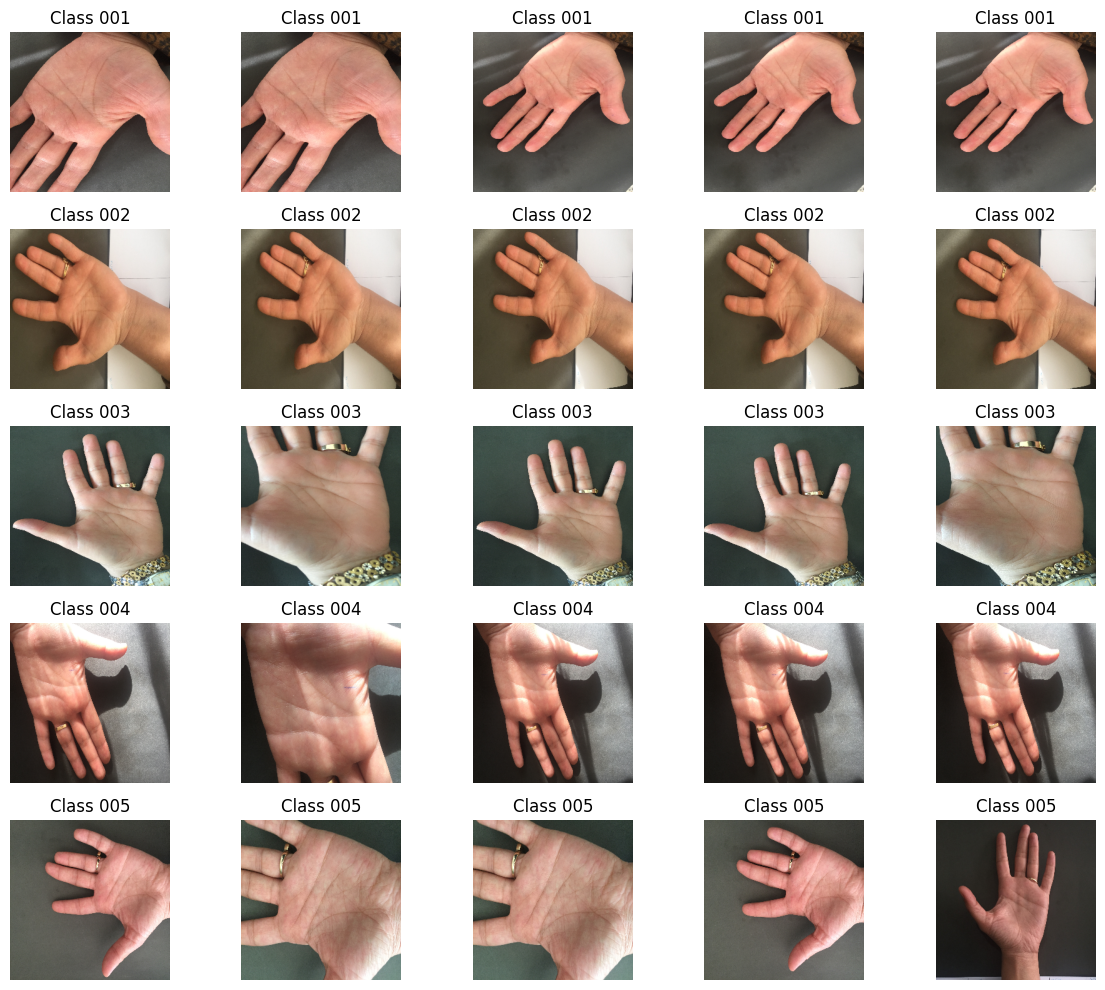

In [16]:
data, labels = load_dataset(RAW_PATH)
print(f"Dataset loaded with {len(data)} images.")

if len(data) == 0:
    print("No images found to display.")
else:
    unique_classes = np.unique(labels)[:5]      # ambil 5 kelas pertama saja
    num_display = 5                             # 5 gambar per kelas
    
    plt.figure(figsize=(12, 10))

    plot_index = 1
    for cls in unique_classes:
        # ambil indeks gambar milik kelas ini
        class_indices = np.where(labels == cls)[0][:num_display]

        for idx in class_indices:
            img = data[idx]

            # convert BGR -> RGB hanya untuk display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(unique_classes), num_display, plot_index)
            plt.imshow(img_rgb)
            plt.title(f"Class {cls}")
            plt.axis("off")
            plot_index += 1

    plt.tight_layout()
    plt.show()

In [50]:
from collections import defaultdict

def split_dataset():
    train_ratio, val_ratio, test_ratio = RATIOS
    
    print("Splitting dataset...")

    # buat folder output
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(SPLIT_PATH, split), exist_ok=True)

    # counter untuk ringkasan
    split_counts = {
        "train": defaultdict(int),
        "val": defaultdict(int),
        "test": defaultdict(int),
    }

    for label in os.listdir(RAW_PATH):
        label_path = os.path.join(RAW_PATH, label)
        if not os.path.isdir(label_path):
            continue

        images = [f for f in os.listdir(label_path)]
        train_imgs, temp = train_test_split(images, test_size=1-train_ratio, random_state=42)
        val_imgs, test_imgs = train_test_split(temp, test_size=test_ratio/(test_ratio+val_ratio), random_state=42)

        for split_name, split_imgs in zip(
            ["train", "val", "test"], 
            [train_imgs, val_imgs, test_imgs]
        ):
            split_label_dir = os.path.join(SPLIT_PATH, split_name, label)
            os.makedirs(split_label_dir, exist_ok=True)

            for img in split_imgs:
                src = os.path.join(label_path, img)
                dst = os.path.join(split_label_dir, img)
                shutil.copy2(src, dst)

            # simpan jumlah per kelas
            split_counts[split_name][label] += len(split_imgs)

    print("Dataset split complete.\n")

    # ================= SUMMARY =================
    for split_name in ["train", "val", "test"]:
        class_count = len(split_counts[split_name])
        total_images = sum(split_counts[split_name].values())

        print(f"=== {split_name.upper()} ===")
        print(f"Jumlah kelas : {class_count}")
        print(f"Jumlah gambar: {total_images}")

        for label, n in split_counts[split_name].items():
            print(f"  - {label}: {n}")

        print()   # baris kosong

split_dataset()

Splitting dataset...
Dataset split complete.

=== TRAIN ===
Jumlah kelas : 10
Jumlah gambar: 300
  - 001: 30
  - 002: 30
  - 003: 30
  - 004: 30
  - 005: 30
  - 006: 30
  - 007: 30
  - 008: 30
  - 009: 30
  - 010: 30

=== VAL ===
Jumlah kelas : 10
Jumlah gambar: 40
  - 001: 4
  - 002: 4
  - 003: 4
  - 004: 4
  - 005: 4
  - 006: 4
  - 007: 4
  - 008: 4
  - 009: 4
  - 010: 4

=== TEST ===
Jumlah kelas : 10
Jumlah gambar: 60
  - 001: 6
  - 002: 6
  - 003: 6
  - 004: 6
  - 005: 6
  - 006: 6
  - 007: 6
  - 008: 6
  - 009: 6
  - 010: 6



In [17]:
def load_split(split_dir):
    data, labels = [], []
    label_encoder = LabelEncoder()
    
    for label in os.listdir(split_dir):
        label_path = os.path.join(split_dir, label)
        if not os.path.isdir(label_path):
            continue
        
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            img = cv2.resize(img, (256, 256))
            data.append(img)
            labels.append(label)

    labels = label_encoder.fit_transform(labels)

    data = np.array(data, dtype="float32") / 255.0
    data = np.expand_dims(data, axis=-1)

    return data, np.array(labels), label_encoder

In [18]:
train_data, train_labels, label_encoder = load_split(os.path.join(SPLIT_PATH, "train"))
val_data,   val_labels, _   = load_split(os.path.join(SPLIT_PATH, "val"))
test_data,  test_labels, _  = load_split(os.path.join(SPLIT_PATH, "test"))

## Model Baseline SimpleCNN

In [19]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(np.unique(train_labels)), activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


c:\Users\ntshd\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,510,282 (120.20 MB)

 Trainable params: 31,510,282 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
print("Training baseline CNN...")
cnn_history = cnn_model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=30,
    batch_size=32
)

Training baseline CNN...
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 924ms/step - accuracy: 0.1567 - loss: 5.1150 - val_accuracy: 0.3750 - val_loss: 2.1802
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 838ms/step - accuracy: 0.3500 - loss: 1.9794 - val_accuracy: 0.7000 - val_loss: 1.3963
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 740ms/step - accuracy: 0.6800 - loss: 1.1118 - val_accuracy: 0.8500 - val_loss: 0.6955
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step - accuracy: 0.8533 - loss: 0.5212 - val_accuracy: 0.9000 - val_loss: 0.4883
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - accuracy: 0.9533 - loss: 0.2499 - val_accuracy: 0.9250 - val_loss: 0.2326
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 605ms/step - accuracy: 0.9600 - loss: 0.1351 - val_accuracy: 0.9000 - val_loss: 0.2676
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.9900 - loss: 0.0781 - val_accuracy: 0.8750 - val_loss: 0.2514
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - accuracy: 0.9767 - loss:

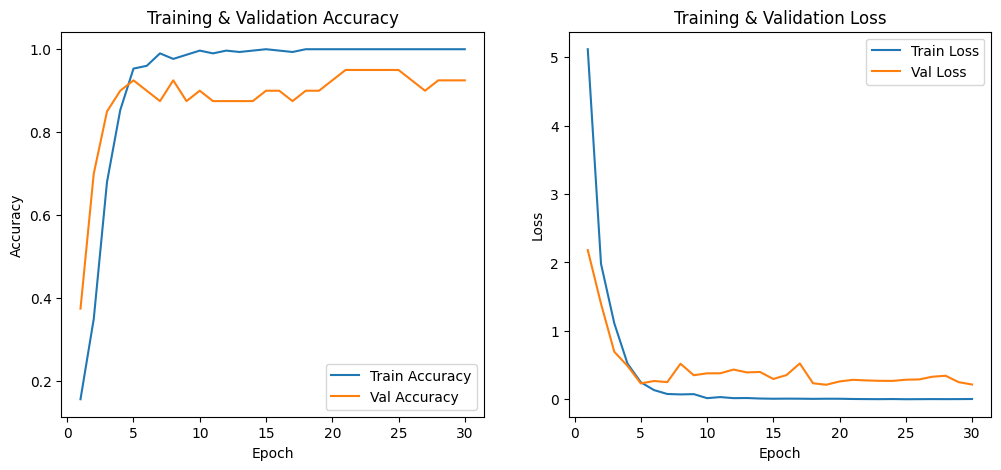

In [21]:
def plot_training(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))

    # accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_training(cnn_history)

Hasil evaluasi

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.9333 - loss: 0.1818
Test accuracy: 0.9333
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


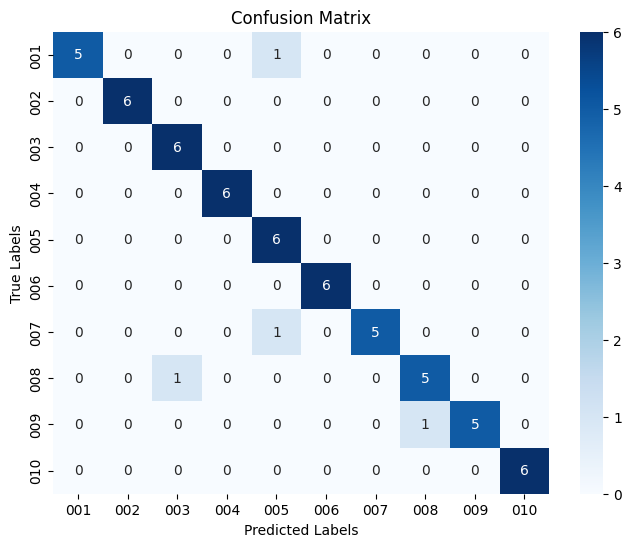

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions for the test set
test_preds = cnn_model.predict(test_data)
test_preds_classes = np.argmax(test_preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds_classes)

# Decode class indices back to class labels
class_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Praproses dataset

In [23]:
def enhance_palmprint(enhanced):
   # --- 1) bank orientasi & frekuensi ---
    orientations = [i * math.pi / 8 for i in range(8)]   # 0 .. 157.5 deg
    lambdas = [6.0, 10.0, 14.0]                          # frekuensi garis telapak
    gamma = 0.5                                          # aspect ratio
    sigma = 0.56 * max(lambdas)                          # aturan Gabor umum

    fused = np.zeros_like(enhanced, dtype=np.float32)

    for lam in lambdas:
        for theta in orientations:
            ksize = int(round(8 * sigma)) | 1            # pastikan ganjil
            kernel = cv2.getGaborKernel(
                (ksize, ksize),
                sigma=sigma,
                theta=theta,
                lambd=lam,
                gamma=gamma,
                psi=0,
                ktype=cv2.CV_32F,
            )

            resp = cv2.filter2D(enhanced, cv2.CV_32F, kernel)

            # --- 2) gunakan magnitude (supaya garis hitam/putih muncul) ---
            resp = np.abs(resp)

            # --- 3) normalisasi respons filter ini ---
            resp = cv2.normalize(resp, None, 0, 1, cv2.NORM_MINMAX)

            # --- 4) fuse: pilih respons paling kuat ---
            fused = np.maximum(fused, resp)

    # # --- 5) masking telapak (opsional tapi disarankan) ---
    # if mask is not None:
    #     fused = fused * (mask.astype(np.float32) / 255.0)

    # --- 6) normalisasi ulang + kontras ---
    fused = cv2.normalize(fused, None, 0, 255, cv2.NORM_MINMAX)
    fused = fused.astype(np.uint8)

    # sedikit penajaman lembut
    fused = cv2.GaussianBlur(fused, (3, 3), 0)
    fused = cv2.addWeighted(fused, 1.5, enhanced, -0.5, 0)

    return fused

# Preprocessing steps
def preprocess_image(img):
    # Step 1: Segment hand palm (using thresholding and contour detection)
    _, binary = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour (assumed to be the hand)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    segmented = cv2.bitwise_and(img, img, mask=mask)

    # Step 2: Extract ROI (bounding box around the largest contour)
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi = segmented[y:y+h, x:x+w]

    # Resize ROI to a fixed size (e.g., 256x256)
    roi = cv2.resize(roi, (256, 256))

    # Step 3: Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(roi)

    # Step 4: Apply Gabor filter
    filtered = enhance_palmprint(enhanced)

    return filtered, enhanced, roi, segmented

def preprocess_split_datasets(split_path=SPLIT_PATH, output_root=PREPROCESSED_PATH):

    splits = ["train", "val", "test"]
    i = 0

    for split in splits:
        input_path  = os.path.join(split_path, split)
        output_path = os.path.join(output_root, split)

        os.makedirs(output_path, exist_ok=True)

        print(f"\nProcessing split: {split}")

        for label in os.listdir(input_path):
            label_path = os.path.join(input_path, label)
            if not os.path.isdir(label_path):
                continue

            output_label_path = os.path.join(output_path, label)
            os.makedirs(output_label_path, exist_ok=True)

            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                processed_img, enhanced, roi, segmented = preprocess_image(img)

                # tampilkan contoh (maks 5 gambar total)
                if i < 5:
                    plt.figure(figsize=(12, 8))

                    plt.subplot(2, 4, 1)
                    plt.imshow(img, cmap='gray')
                    plt.title('Original')
                    plt.axis('off')

                    plt.subplot(2, 4, 2)
                    plt.imshow(segmented, cmap='gray')
                    plt.title('Segmented Palm')
                    plt.axis('off')

                    plt.subplot(2, 4, 3)
                    plt.imshow(enhanced, cmap='gray')
                    plt.title('CLAHE')
                    plt.axis('off')

                    plt.subplot(2, 4, 4)
                    plt.imshow(processed_img, cmap='gray')
                    plt.title('Gabor Enhanced')
                    plt.axis('off')

                    plt.suptitle(f'{split}/{label}/{img_name}', fontsize=14)
                    plt.tight_layout()
                    plt.show()

                i += 1

                out_img_path = os.path.join(output_label_path, img_name)
                cv2.imwrite(out_img_path, processed_img)

    print("\nPreprocessing for all splits COMPLETE!")

Preprocessing dataset...

Processing split: train


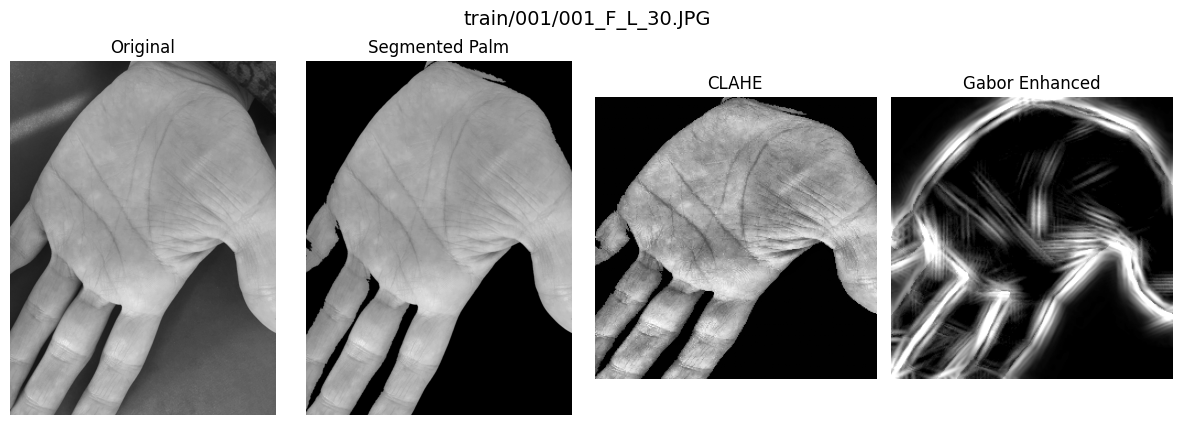

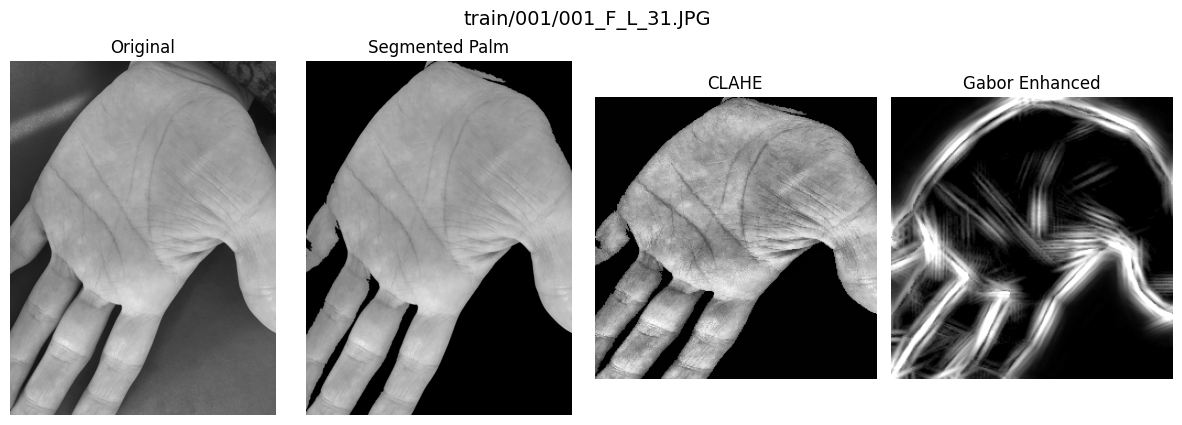

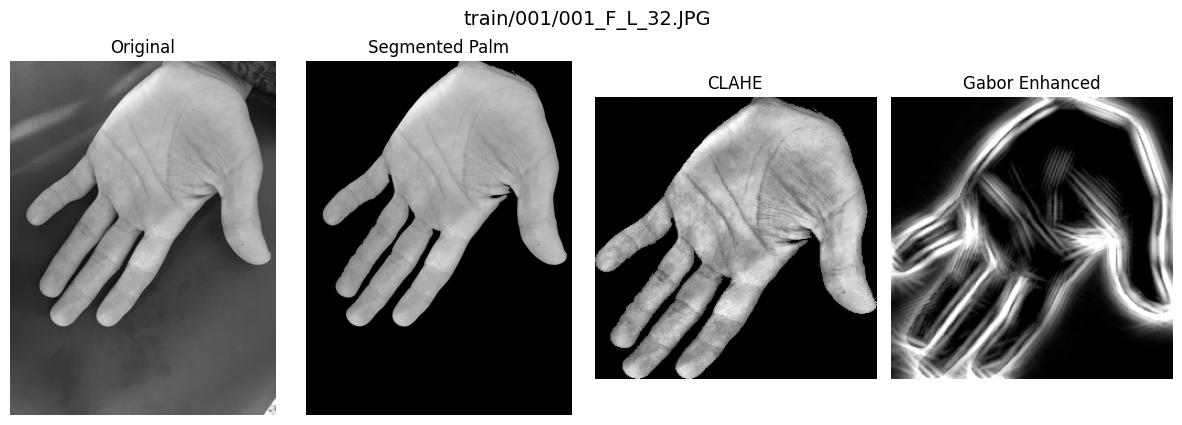

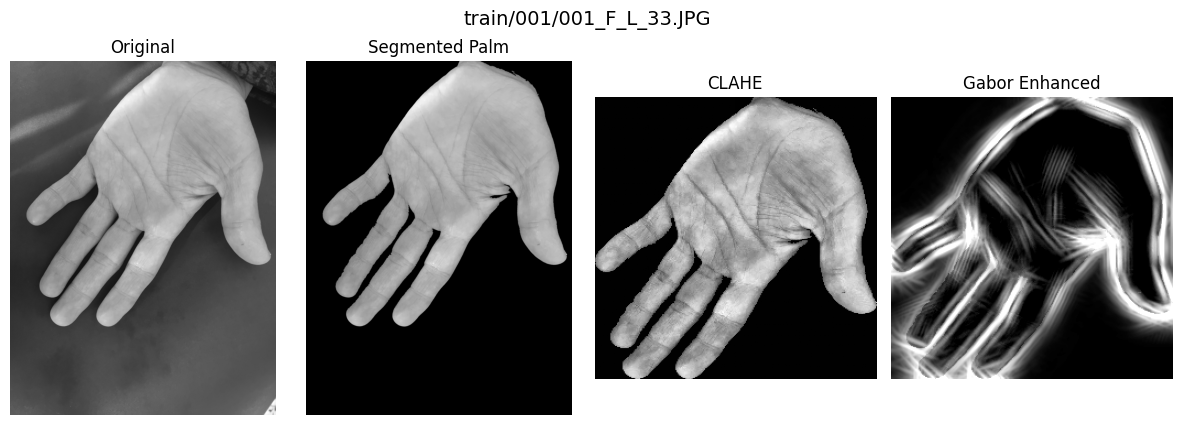

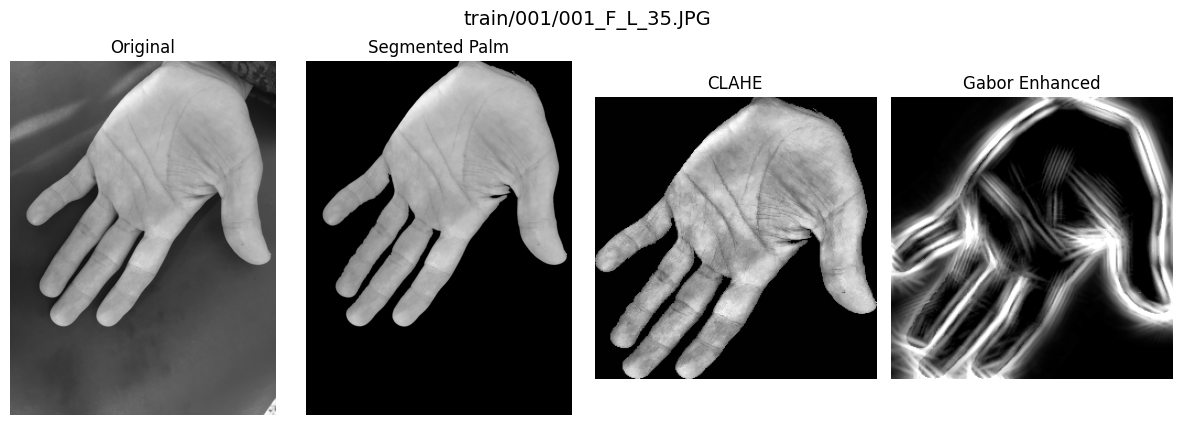


Processing split: val

Processing split: test

Preprocessing for all splits COMPLETE!
Preprocessing complete. Preprocessed dataset saved to: preprocessed_dataset


In [24]:
# Preprocess and save dataset
print('Preprocessing dataset...')
preprocess_split_datasets(SPLIT_PATH, PREPROCESSED_PATH)
print('Preprocessing complete. Preprocessed dataset saved to:', PREPROCESSED_PATH)

In [25]:
train_data, train_labels, label_encoder = load_split(os.path.join(PREPROCESSED_PATH, "train"))
val_data,   val_labels, _   = load_split(os.path.join(PREPROCESSED_PATH, "val"))
test_data,  test_labels, _  = load_split(os.path.join(PREPROCESSED_PATH, "test"))

In [26]:
train_data.shape

(300, 256, 256, 1)

In [27]:
print("Training preprocessed + baseline CNN...")
cnn_history = cnn_model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=30,
    batch_size=32
)

Training preprocessed + baseline CNN...
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 761ms/step - accuracy: 0.1333 - loss: 4.8658 - val_accuracy: 0.5000 - val_loss: 2.2408
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.2667 - loss: 2.1462 - val_accuracy: 0.6500 - val_loss: 1.7338
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 602ms/step - accuracy: 0.4367 - loss: 1.6714 - val_accuracy: 0.7000 - val_loss: 1.0852
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.5067 - loss: 1.3426 - val_accuracy: 0.8750 - val_loss: 0.7567
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.6200 - loss: 1.0697 - val_accuracy: 0.8750 - val_loss: 0.4979
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - accuracy: 0.7267 - loss: 0.7933 - val_accuracy: 0.9000 - val_loss: 0.2999
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 705ms/step - accuracy: 0.7433 - loss: 0.6703 - val_accuracy: 0.9250 - val_loss: 0.3591
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 624ms/step - accuracy: 

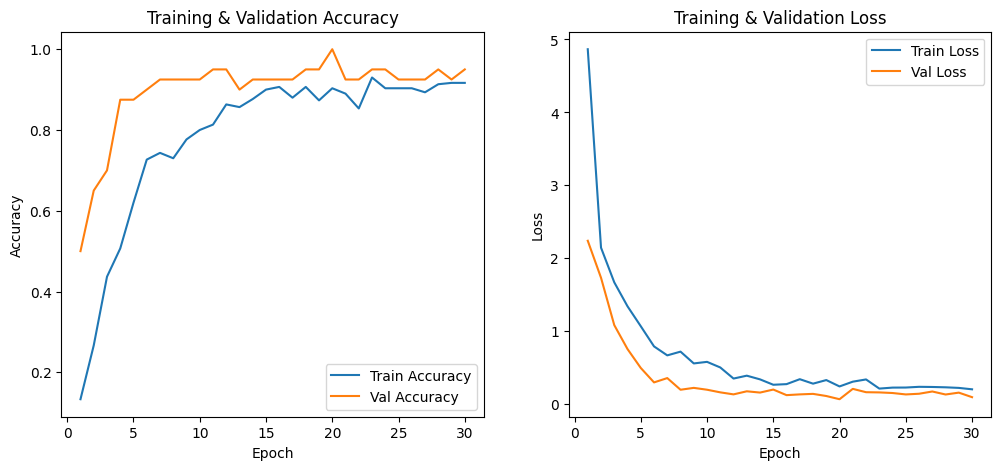

In [28]:
plot_training(cnn_history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8833 - loss: 0.4235
Test accuracy: 0.8833
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


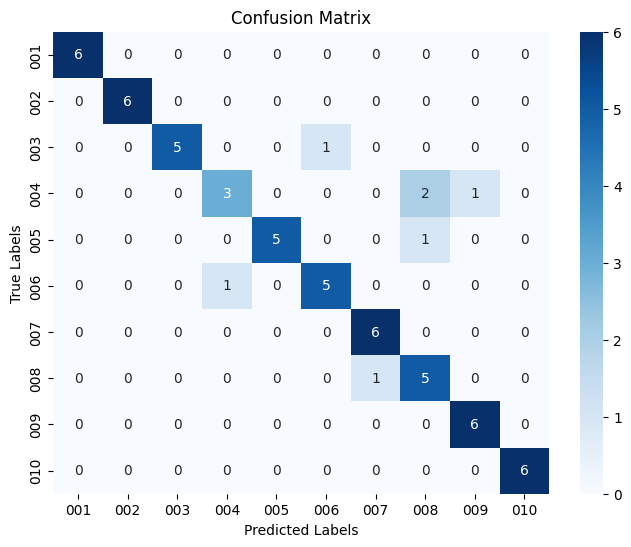

In [29]:
# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions for the test set
test_preds = cnn_model.predict(test_data)
test_preds_classes = np.argmax(test_preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds_classes)

# Decode class indices back to class labels
class_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
train_data.shape

(300, 256, 256, 1)

In [31]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# ---- Ubah grayscale (256,256,1) menjadi RGB (256,256,3)
train_data_rgb = np.repeat(train_data, 3, axis=-1)
val_data_rgb   = np.repeat(val_data, 3, axis=-1)

def build_mobilenet(input_shape, num_classes):
    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )

    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

num_classes = len(np.unique(train_labels))
input_shape = (256, 256, 3)

mobilenet = build_mobilenet(input_shape, num_classes)

mobilenet_hist = mobilenet.fit(
    train_data_rgb, train_labels,
    validation_data=(val_data_rgb, val_labels),
    epochs=30,
    batch_size=32
)


C:\Users\ntshd\AppData\Local\Temp\ipykernel_11068\3455715146.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 806ms/step - accuracy: 0.1200 - loss: 2.6879 - val_accuracy: 0.2000 - val_loss: 2.1247
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.2300 - loss: 2.1339 - val_accuracy: 0.5750 - val_loss: 1.7393
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - accuracy: 0.3967 - loss: 1.7309 - val_accuracy: 0.6250 - val_loss: 1.4288
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - accuracy: 0.5667 - loss: 1.4443 - val_accuracy: 0.8000 - val_loss: 1.2002
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - accuracy: 0.6500 - loss: 1.1964 - val_accuracy: 0.7500 - val_loss: 1.0315
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - accuracy: 0.7467 - loss: 0.9747 - val_accuracy: 0.9000 - val_loss: 0.9057
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.7867 - loss: 0.8556 - val_accuracy: 0.8500 - val_loss: 0.7913
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - accuracy: 0.8500 - loss: 0.7117 - val_accuracy: 0

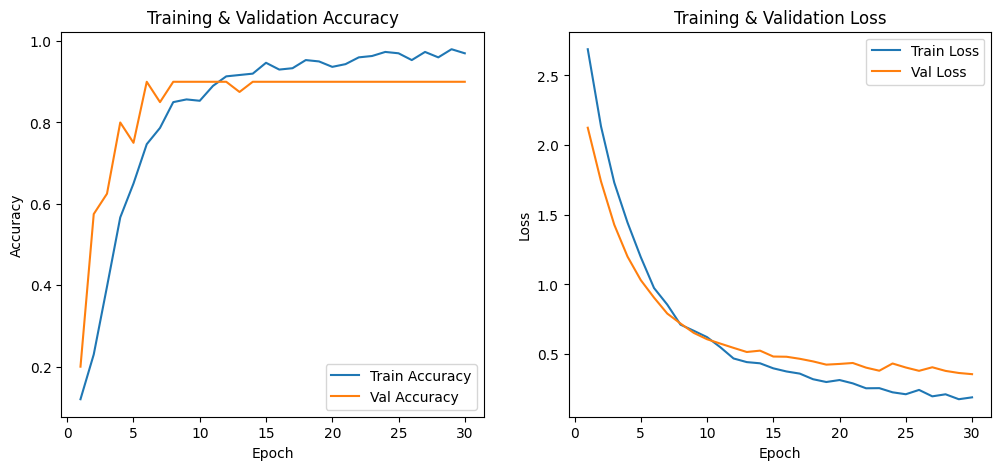

In [32]:
plot_training(mobilenet_hist)

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

def build_vgg(input_shape, num_classes):
    base = VGG16(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )

    # freeze feature extractor
    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base.input, outputs=out)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

num_classes = len(np.unique(train_labels))
input_shape = (256, 256, 3)

vgg_model = build_vgg(input_shape, num_classes)

history_vgg = vgg_model.fit(
    train_data_rgb, train_labels,
    validation_data=(val_data_rgb, val_labels),
    epochs=30,
    batch_size=32
)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.0900 - loss: 2.5223 - val_accuracy: 0.1250 - val_loss: 2.2879
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.0767 - loss: 2.4268 - val_accuracy: 0.1500 - val_loss: 2.2529
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step - accuracy: 0.1133 - loss: 2.3672 - val_accuracy: 0.2250 - val_loss: 2.2400
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 7s/step - accuracy: 0.1700 - loss: 2.2999 - val_accuracy: 0.3000 - val_loss: 2.2204
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 7s/step - accuracy: 0.1767 - loss: 2.2659 - val_accuracy: 0.3000 - val_loss: 2.1947
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.1767 - loss: 2.2904 - val_accuracy: 0.5250 - val_loss: 2.1735
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.1567 - loss: 2.2684 - val_accuracy: 0.5250 - val_loss: 2.1543
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 0.1567 - loss: 2.2587 - val_accuracy: 0.6500 - val_loss:

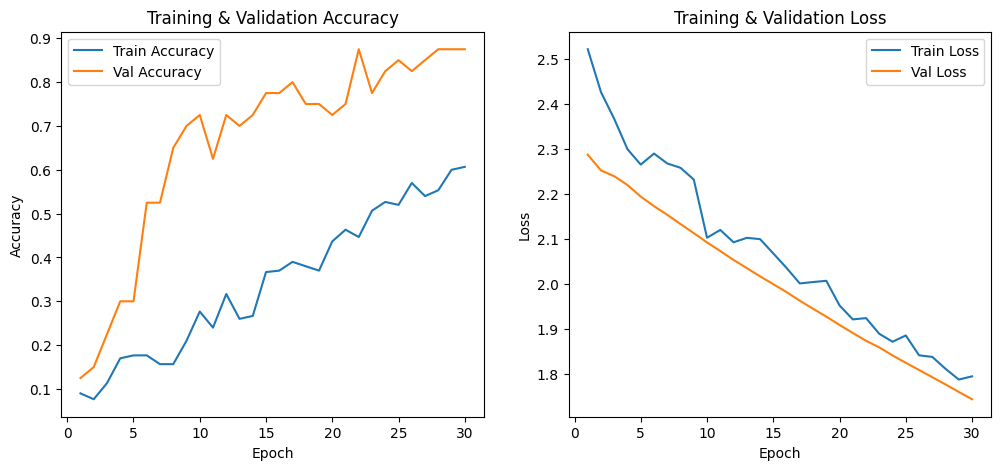

In [34]:
plot_training(history_vgg)